<a href="https://colab.research.google.com/github/SMTorg/smt/blob/master/tutorial/NotebookRunTestCases_Paper_SMT_v2.ipynb" target="_blank" rel="nofollow"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"></a> 

<div class="jumbotron text-left">
    <b>
This tutorial is associated to the journal paper about SMT 2.0.
</b>

The published paper is available https://doi.org/10.1016/j.advengsoft.2023.103571 
    
`SMT 2.0`: A Surrogate Modeling Toolbox with a focus on Hierarchical and Mixed Variables Gaussian Processes

</div>


Authors: Paul Saves and  Nathalie BARTOLI ONERA/DTIS/M2CI - June 2023
based on `SMT 2.0 version` 

Update: May 2024 `SMT version 2.5.1`

<div class="alert alert-info fade in" id="d110">
<p>To run the test cases presented in the associated paper</p>
<ol> - Build a surrogate model with hierarchical variables and check that inactive variables have no effect on the output </ol>
<ol> - Build a surrogate model using `numba` to reduce CPU time (for large DOE) </ol>
<ol> -  Bayesian optimization of a mixed integer function (toy function)    </ol>
<ol> -   Bayesian optimization of the mixed Branin test function: a mixed integer problem  </ol>
<ol> -   Bayesian optimization of a mixed categorical function (Goldstein function)   </ol>
</div>``

In [1]:
# to have the latest version
!pip install smt --pre

In [2]:
# to ignore warning messages
import warnings


import numpy as np
import matplotlib.pyplot as plt
import time

from smt.applications import EGO
from smt.problems import Branin, HierarchicalGoldstein
from smt.sampling_methods import FullFactorial
from smt.sampling_methods import LHS
from smt.surrogate_models import (
    KRG,
    MixIntKernelType,
    MixHrcKernelType,
)
from smt.applications.mixed_integer import (
    MixedIntegerSamplingMethod,
    MixedIntegerKrigingModel,
)

from smt.utils.design_space import (
    DesignSpace,
    FloatVariable,
    IntegerVariable,
    CategoricalVariable,
)

warnings.filterwarnings("ignore")
%matplotlib inline

## Build the kriging model associated to the Multi-Layer perceptron model: a kriging with meta variables

<div class="jumbotron text-left">
The objective is to build the surrogate model described in Figure 5 of the SMT2.0 paper.
</div>

In [3]:
def f_neu(x1, x2, x3):
    return 2 * x1 + x2 - 0.5 * x3


def f1(x1, x2, x3, x4):
    return f_neu(x1, x2, x3) + x4**2


def f2(x1, x2, x3, x4, x5):
    return f_neu(x1, x2, x3) + (x4**2) + 0.3 * x5


def f3(x1, x2, x3, x4, x5, x6):
    return f_neu(x1, x2, x3) + (x4**2) + 0.3 * x5 - 0.1 * x6**3


def f(X):
    y = []
    for x in X:
        if x[0] == 1:
            y.append(f1(x[1], x[2], x[3], x[4]))
        elif x[0] == 2:
            y.append(f2(x[1], x[2], x[3], x[4], x[5]))
        elif x[0] == 3:
            y.append(f3(x[1], x[2], x[3], x[4], x[5], x[6]))
    return np.array(y)


# Define the mixed hierarchical design space
# x0 to x6 defined
design_space = DesignSpace(
    [
        IntegerVariable(1, 3),  # for the number of hidden layers (l=x0)
        FloatVariable(-5, -2),  # instead of [1e-5, 1e-2]  for the learning rate
        CategoricalVariable(
            ["ReLU ", "SELU", "ISRLU"]
        ),  # 3 possible choices for the activation function
        IntegerVariable(
            3, 8
        ),  # instead of ["2**3=8", "2**4=16", "2**5=32", "2**6=64", "2**7=128", "2**8=256"] for the batch size
        IntegerVariable(
            0, 5
        ),  # instead of [50,55] - activate when x0=1 - number of hidden neurons
        IntegerVariable(
            0, 5
        ),  # instead of [50,55] - activate when x0=2 - number of hidden neurons
        IntegerVariable(
            0, 5
        ),  # instead of [50,55] - activate when x0=3 - number of hidden neurons
    ]
)

# activate x5 when x0 in [2, 3]; x6 when x0 == 3
design_space.declare_decreed_var(decreed_var=5, meta_var=0, meta_value=[2, 3])
design_space.declare_decreed_var(decreed_var=6, meta_var=0, meta_value=3)

# Perform the mixed integer sampling - LHS DOE
n_doe = 100
Xt, _ = design_space.sample_valid_x(n_doe)
Yt = f(Xt)

# Build the surrogate

sm = MixedIntegerKrigingModel(
    surrogate=KRG(
        design_space=design_space,
        categorical_kernel=MixIntKernelType.HOMO_HSPHERE,
        hierarchical_kernel=MixHrcKernelType.ALG_KERNEL,
        theta0=[1e-2],
        corr="abs_exp",
        n_start=5,
        print_global=False,
    )
)
sm.set_training_values(Xt, Yt)
sm.train()


# Check prediction and variance accuracy
y_s = sm.predict_values(Xt)[:, 0]
pred_RMSE = np.linalg.norm(y_s - Yt) / len(Yt)

y_sv = sm.predict_variances(Xt)[:, 0]
var_RMSE = np.linalg.norm(y_sv) / len(Yt)

print("Pred_RMSE on the training points", pred_RMSE)
print("Var_RMSE on the training points", var_RMSE)

Pred_RMSE on the training points 8.490185777651479e-14
Var_RMSE on the training points 0.0


In [4]:
# To check of some inactive variables have no effect on the output
xv1 = np.array(
    [
        [1, -1, 2, 3, 2, 0, 0],  # x[5] and x[6] may change without effect
        [2, -2, 1, 4, 2, 1, 0],  # x[6] may change without effect
        [3, -3, 0, 5, 2, 1, 5],  # all have an effect
    ]
)
xv2 = np.array(
    [
        [1, -1, 2, 3, 2, 5, 5],
        [2, -2, 1, 4, 2, 1, 5],
        [3, -3, 0, 5, 2, 1, 5],
    ]
)
yv1 = sm.predict_values(xv1)[:, 0]
yv2 = sm.predict_values(xv2)[:, 0]
print(yv1, yv2)
print(
    "The outputs must be similar (inactive variables have no effect)",
    np.linalg.norm(yv1 - yv2),
)

# To check of some active variables have an effect on the output
xv3 = np.array([[1, -1, 2, 8, 2, 0, 0]])  # all have an effect
xv4 = np.array([[1, -1, 2, 8, 4, 5, 5]])
yv3 = sm.predict_values(xv3)[:, 0]
yv4 = sm.predict_values(xv4)[:, 0]
print(yv3, yv4)
print(
    "The outputs must be different (active variables have effect)",
    np.linalg.norm(yv3 - yv4),
)

[-2.590322   -0.18469433 -3.66715808] [-2.590322   -0.18469433 -3.66715808]
The outputs must be similar (inactive variables have no effect) 0.0
[-5.33407852] [5.1066967]
The outputs must be different (active variables have effect) 10.440775222926586


In [5]:
# To have access to the "real" values of the input space variables
x2_decoded = design_space.decode_values(xv1, i_dv=2)
print("Activation function", x2_decoded)
x3_decoded = design_space.decode_values(xv1, i_dv=3)
print("Batch size ", x3_decoded)
x4_decoded = design_space.decode_values(xv1, i_dv=4)
print("Number of hidden neurons -1st layer ", x4_decoded)
x5_decoded = design_space.decode_values(xv1, i_dv=5)
print("Number of hidden neurons -2nd layer", x5_decoded)
x6_decoded = design_space.decode_values(xv1, i_dv=6)
print("Number of hidden neurons -3rd layer", x6_decoded)

Activation function ['ISRLU', 'SELU', 'ReLU ']
Batch size  [3, 4, 5]
Number of hidden neurons -1st layer  [2, 2, 2]
Number of hidden neurons -2nd layer [0, 1, 1]
Number of hidden neurons -3rd layer [0, 0, 5]


## Build surrogate model using Numba to reduce CPU time 

<div class="jumbotron text-left">
The objective is to build the surrogate model described in Table 2 of the SMT2.0 paper. 
</div>

<div class="alert alert-warning" >
If you use hierarchical variables and the size of your doe greater than 30 points, you may leverage the `numba` JIT compiler to speed up the computation
To do so:
    
 - install numba library
    
     `pip install numba`
    
    
 - and define the environment variable `USE_NUMBA_JIT = 1` (unset or 0 if you do not want to use numba) 
    
     - Linux: export USE_NUMBA_JIT = 1
    
     - Windows: set USE_NUMBA_JIT = 1

</div>

In [6]:
# to check if numba is available
!pip show numba
# and then you need to define the environment variable USE_NUMBA_JIT
!echo "Numba used or not in your environment=" %USE_NUMBA_JIT%

Name: numba
Version: 0.60.0
Summary: compiling Python code using LLVM
Home-page: https://numba.pydata.org
Author: 
Author-email: 
License: BSD
Location: /stck/psaves/miniconda3/envs/newenv1/lib/python3.9/site-packages
Requires: llvmlite, numpy
Required-by: adsg-core
Numba used or not in your environment= %USE_NUMBA_JIT%


In [7]:
# compare the CPU time to build a DOE with 15 or 150 points
problem = HierarchicalGoldstein()
design_space = problem.design_space
print(design_space)
# for 15 points
n_doe = 15
design_space.seed = 42

start = time.time()
Xt1, is_acting = design_space.sample_valid_x(n_doe)
end = time.time()
print("for ", n_doe, "points time is = ", end - start)
Yt1 = problem(Xt1)

# for 150 points
n_doe = 150
design_space.seed = 42

start = time.time()
Xt2, is_acting = design_space.sample_valid_x(n_doe)
end = time.time()
print("for ", n_doe, "points time is = ", end - start)
Yt2 = problem(Xt2)

Design space:
x0: Cat [0, 1, 2, 3]
x1: Ord [0, 1]
x2: Float (0, 100)
x3: Float (0, 100)
x4: Float (0, 100)
x5: Float (0, 100)
x6: Float (0, 100)
x7: Int (0, 2)
x8: Int (0, 2)
x9: Int (0, 2)
x10: Int (0, 2)
for  15 points time is =  0.0023741722106933594
for  150 points time is =  0.0025701522827148438


## Bayesian optimization of the toy function: a mixed integer problem

<div class="jumbotron text-left">
The objective is to solve the optimization problem (Toy problem) described in Figure 6 of the SMT2.0 paper. The problem is also described in Appendix A ot the mentionned paper.
 </div>

First, we recall the optimization problem:

$$
\begin{array}{ll}
& \min  f( x^{cat}, x^{quant}) \\
& \mbox{w.r.t.} \ \  x^{cat} = c_1 \in \{ 0,1,2,3,4,5,6,7,8,9 \} \\
& \quad \quad \quad x^{quant} = x_1 \in \{ 0,1 \} 
\end{array}
$$


The toy function $f$ is defined as
$$
\begin{array}{ll}
   f({x_1}, {c_1})  = &  \mathbb{1}_{c_1=0}  \ \cos(3.6 \pi(x-2)) +x -1 \\
    & + \mathbb{1}_{c_1=1} \ 2 \cos(1.1 \pi \exp(x)) - \frac{x}{2} +2  \\
    & + \mathbb{1}_{c_1=2}  \  \cos ( 2 \pi x)  + \frac{1}{2}x \\
 & + \mathbb{1}_{c_1=3}  \  x ( \cos(3.4 \pi (x-1)) - \frac{x-1}{2})\\
 & + \mathbb{1}_{c_1=4}  \   - \frac{x^2}{2} \\
& + \mathbb{1}_{c_1=5}  \  2 \cos(0.25 \pi \exp( -x^4))^2 - \frac{x}{2} +1 \\ 
& + \mathbb{1}_{c_1=6}   \ x \cos(3.4 \pi x ) - \frac{x}{2} +1 \\ 
& + \mathbb{1}_{c_1=7}   \  - x  (\cos(3.5 \pi x ) + \frac{x}{2}) +2 \\ 
& + \mathbb{1}_{c_1=8}   \ - \frac{x^5}{2} +1 \\ 
& + \mathbb{1}_{c_1=9}  \  - \cos (2.5 \pi x)^2 \sqrt{x} - 0.5 \ln (x+0.5)  - 1.3
\end{array}
$$


In [8]:
def f_obj(X):
    """
    s01 objective

    Parameters
    ----------
    point: array_like
        point to evaluate
    """
    PI = 3.14159265358979323846
    x = X[:, 0]
    # categorial variable
    c = X[:, 1]
    x = np.abs(x)
    c1 = c == 0
    c2 = c == 1
    c3 = c == 2
    c4 = c == 3
    c5 = c == 4
    c6 = c == 5
    c7 = c == 6
    c8 = c == 7
    c9 = c == 8
    c10 = c == 9
    if np.size(c1) == (
        np.sum(c1)
        + np.sum(c2)
        + np.sum(c3)
        + np.sum(c4)
        + np.sum(c5)
        + np.sum(c6)
        + np.sum(c7)
        + np.sum(c8)
        + np.sum(c9)
        + np.sum(c10)
    ):
        y = (
            c1 * (np.cos(3.6 * PI * (x - 2)) + x - 1)
            + c2 * (2 * np.cos(1.1 * PI * np.exp(x)) - x / 2 + 2)
            + c3 * (np.cos(2 * PI * x) + x / 2)
            + c4 * (x * (np.cos(3.4 * PI * (x - 1)) - (x - 1) / 2))
            + c5 * (-0.5 * x * x)
            + c6
            * (2 * np.power(np.cos(0.25 * PI * np.exp(-np.power(x, 4))), 2) - x / 2 + 1)
            + c7 * (x * (np.cos(3.4 * PI * x)) - x / 2 + 1)
            + c8 * (x * (-np.cos(7 * 0.5 * PI * x) - x / 2) + 2)
            + c9 * (-np.power(x, 5) * 0.5 + 1)
            + c10
            * (
                -np.power(np.cos(5 * PI * 0.5 * x), 2) * np.sqrt(x)
                - 0.5 * np.log(x + 0.5)
                - 1.3
            )
        )
    else:
        print("type error")
        print(X)
    return y


# To define the variables x^{quant} and x^{cat}
design_space = DesignSpace(
    [
        FloatVariable(0, 1),  # real
        CategoricalVariable(
            ["1", "2", "3", "4", "5", "6", "7", "8", "9", "10"]
        ),  # 10 possible choices
    ]
)


# To define the initial DOE
random_state = 42  # seed value for the sampling
n_doe = 5  # initial doe size
sampling = MixedIntegerSamplingMethod(
    LHS, design_space, criterion="ese", random_state=random_state
)
Xt = sampling(n_doe)

# To start the Bayesion optimization
n_iter = 20  # number of iterations
criterion = "EI"  # infill criterion
ego = EGO(
    n_iter=n_iter,
    criterion=criterion,
    xdoe=Xt,
    surrogate=KRG(
        design_space=design_space,
        # categorical_kernel= MixIntKernelType.GOWER,
        # categorical_kernel= MixIntKernelType.CONT_RELAX,
        # categorical_kernel=MixIntKernelType.EXP_HOMO_HSPHERE,
        categorical_kernel=MixIntKernelType.HOMO_HSPHERE,
        theta0=[1e-2],
        n_start=15,
        corr="squar_exp",
        print_global=False,
    ),
    verbose=True,
    enable_tunneling=False,
    random_state=random_state,
    n_start=10,
)
x_opt, y_opt, dnk, x_data, y_data = ego.optimize(fun=f_obj)

Initial DOE given
Internal optimization succeeded at EGO iter = 0.0
Internal optimization succeeded at EGO iter = 1.0
Internal optimization succeeded at EGO iter = 2.0
Internal optimization succeeded at EGO iter = 3.0
Internal optimization succeeded at EGO iter = 4.0
Internal optimization succeeded at EGO iter = 5.0
Internal optimization succeeded at EGO iter = 6.0
Internal optimization succeeded at EGO iter = 7.0
Internal optimization succeeded at EGO iter = 8.0
Internal optimization succeeded at EGO iter = 9.0
Internal optimization succeeded at EGO iter = 10.0
Internal optimization succeeded at EGO iter = 11.0
Internal optimization succeeded at EGO iter = 12.0
Internal optimization succeeded at EGO iter = 13.0
Internal optimization succeeded at EGO iter = 14.0
Internal optimization succeeded at EGO iter = 15.0
Internal optimization succeeded at EGO iter = 16.0
Internal optimization succeeded at EGO iter = 17.0
Internal optimization succeeded at EGO iter = 18.0
Internal optimization s

In [9]:
print("Final results:", x_opt, y_opt, dnk, x_data, y_data)

Final results: [0.41459961 9.        ] [-1.89083072] 10 [[ 3.74540119e-01  1.00000000e+00]
 [ 9.50714306e-01  0.00000000e+00]
 [ 7.31993942e-01  8.00000000e+00]
 [ 5.98658484e-01  6.00000000e+00]
 [ 1.56018640e-01  7.00000000e+00]
 [ 9.11733088e-01  4.00000000e+00]
 [ 8.32667268e-17  2.00000000e+00]
 [ 7.44640493e-01  4.00000000e+00]
 [ 2.72978154e-01  4.00000000e+00]
 [ 2.85607649e-01  5.00000000e+00]
 [ 4.14599613e-01  9.00000000e+00]
 [ 8.64710400e-01  3.00000000e+00]
 [ 5.46965888e-01  9.00000000e+00]
 [-2.22044605e-15  9.00000000e+00]
 [ 4.87795799e-01  0.00000000e+00]
 [ 9.60654072e-01  6.00000000e+00]
 [ 3.52174919e-01  3.00000000e+00]
 [ 7.57312000e-01  2.00000000e+00]
 [ 9.71655934e-01  7.00000000e+00]
 [ 2.47849557e-01  8.00000000e+00]
 [ 8.73496442e-02  0.00000000e+00]
 [ 9.68834708e-01  9.00000000e+00]
 [ 5.63980420e-01  4.00000000e+00]
 [ 3.79414921e-01  2.00000000e+00]
 [ 3.04297560e-01  0.00000000e+00]] [[ 2.42929785]
 [ 0.71605296]
 [ 0.89492305]
 [ 1.29562278]
 [ 2.010

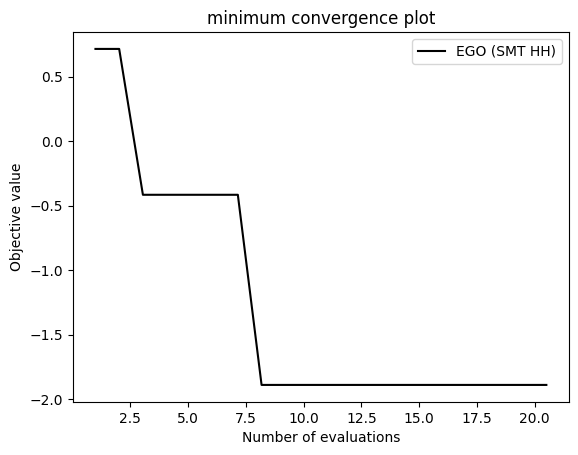

In [10]:
%matplotlib inline

# to plot the objective function during the optimization process
mini = np.zeros(n_iter)
for k in range(n_iter):
    mini[k] = np.min(y_data[0 : k + n_doe - 1])
x_plot = np.linspace(1, n_iter + 0.5, n_iter)
plt.plot(x_plot, mini, color="k", label="EGO (SMT HH)")
plt.legend()
plt.title("minimum convergence plot", loc="center")
plt.xlabel("Number of evaluations")
plt.ylabel("Objective value")
plt.show()

 ## Bayesian optimization of mixed Branin test function: a mixed integer problem

<div class="jumbotron text-left">
  The objective is to solve the optimization problem (Mixed Branin function) described in Figure 7 of the SMT2.0 paper. 
</div>

The 2D function to optimize is described by: 
- 1 discrete variable $\in [-5, 10]$
- 1 continuous variable $\in [0., 15.]$

In [11]:
# Branin function with a integer variable and a continuous variable
fun = Branin(ndim=2)
design_space = fun.design_space

# Initial doe
n_doe = 10
sampling = MixedIntegerSamplingMethod(FullFactorial, design_space)
xdoe = sampling(n_doe)

# Bayesian optimization
n_iter = 20

sm = KRG(
    design_space=design_space,
    print_global=False,
    categorical_kernel=MixIntKernelType.CONT_RELAX,
)
criterion = "EI"  # 'EI' or 'SBO' or 'LCB'

ego = EGO(
    xdoe=xdoe,
    n_iter=n_iter,
    criterion=criterion,
    surrogate=sm,
    enable_tunneling=False,
    random_state=42,
)

x_opt, y_opt, ind_best, x_data, y_data = ego.optimize(fun=fun)
print("Optimal point found", x_opt, y_opt)

Optimal point found [3.14313364 2.28041034] [0.39794247]


[3.14313364 2.28041034] [0.39794247]


Text(0.5, 1.0, 'Mixed Branin - optimization process')

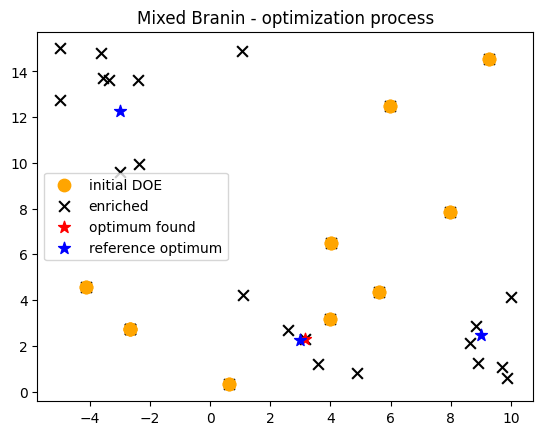

In [12]:
# 3 optimal points possible in the continuous Branin function: [-pi, 12.275], [pi, 2.275], [9.42478, 2.475]
# for the modified integer Branin function
xref = np.array([[-3, 12.275], [3, 2.275], [9, 2.475]])
print(x_opt, y_opt)


fig = plt.figure()
plt.scatter(xdoe.T[0], xdoe.T[1], s=80, marker="o", color="orange", label="initial DOE")
plt.scatter(x_data.T[0], x_data.T[1], s=60, marker="x", color="black", label="enriched")
plt.scatter(xdoe.T[0], xdoe.T[1], s=80, marker="o", color="orange")
plt.scatter(x_opt[0], x_opt[1], s=80, marker="*", color="red", label="optimum found")
plt.scatter(
    xref[:, 0], xref[:, 1], s=80, marker="*", color="blue", label="reference optimum"
)
plt.legend()

plt.title("Mixed Branin - optimization process")

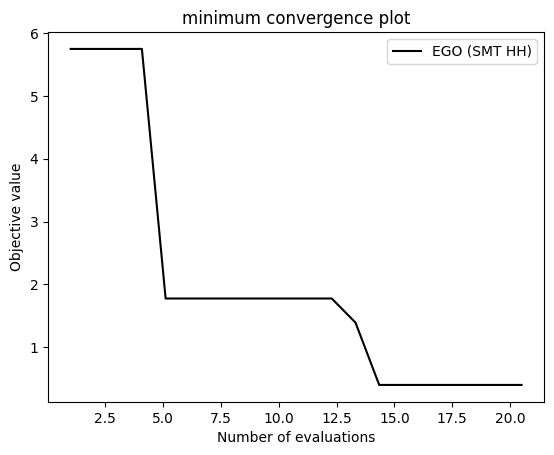

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt

# to plot the objective function during the optimization process
mini = np.zeros(n_iter)
for k in range(n_iter):
    mini[k] = np.min(y_data[0 : k + n_doe - 1])
x_plot = np.linspace(1, n_iter + 0.5, n_iter)
plt.plot(x_plot, mini, color="k", label="EGO (SMT HH)")
plt.legend()
plt.title("minimum convergence plot", loc="center")
plt.xlabel("Number of evaluations")
plt.ylabel("Objective value")
plt.show()

## Bayesian optimization of hierarchical Goldstein test function: a mixed hierarchical problem

<div class="jumbotron text-left">
  The objective is to solve the optimization problem (Hierarchical Goldstein function) described in Figure 7 of the SMT2.0 paper. The problem is also described in Appendix A ot the mentionned paper.
</div>

First, we recall the optimization problem:
\begin{equation}
\begin{split}
& \min  f( x^{cat}_{neutral}, x^{quant}_{neutral}, x^{cat}_{m}, x^{quant}_{decreed}  ) \\
& \mbox{w.r.t.} \ \  x^{cat}_{m} = w_1 \in \{ 0,1,2,3 \} \\
& \quad \quad \quad x^{quant}_{decreed} = (x_3,x_4,z_1,z_2) \in \{ 0,100 \}^2 \times \{ 0,1,2 \}^2   \\
& \quad \quad \quad x^{cat}_{neutral} =w_2 \in \{ 0,1 \} \\
& \quad \quad \quad x^{quant}_{neutral} = (x_1,x_2,x_5,z_3,z_4) \in \{ 0,100 \}^3 \times \{ 0,1,2 \}^2   \\
\end{split}
\end{equation}

The hierarchical and mixed function $f$ is defined as a hierarchical function that depends on $f_0$, $f_1$, $f_2$ and $Gold_\text{cont}$ as follows
\begin{equation}
\begin{split}
   &f({x_1}, {x_2}, {x_3}, {x_4}, {z_1}, {z_2}, {z_3}, {z_4}, {x_5}, {w_1}, {w_2})  = \\
    &  \quad \  \mathbb{1}_{w_1=0} f_0( {x_1}, {x_2},  {z_1}, {z_2}, {z_3}, {z_4}, {x_5}, {w_2}) \\
    & + \mathbb{1}_{w_1=1} f_1 ({x_1}, {x_2}, {x_3}, {z_2}, {z_3}, {z_4}, {x_5}, {w_2})  \\
    & + \mathbb{1}_{w_1=2} f_2 ({x_1}, {x_2}, {x_4}, {z_1}, {z_3}, {z_4}, {x_5}, {w_2})  \\
   & + \mathbb{1}_{w_1=3}  Gold_{\text{cont}} ({x_1}, {x_2}, {x_3}, {x_4}, {z_3}, {z_4}, {x_5},  {w_2}).
\end{split}
\end{equation}

Then, the functions $f_0$, $f_1$ and $f_2$ are defined as mixed variants of $Gold_\text{cont}$ as such

\begin{equation}
\begin{split}
   f_0( {x_1}, {x_2},  {z_1}, {z_2}, {z_3}, {z_4}, {x_5}, {w_2})  = &\\
       & \mathbb{1}_{z_2=0} \big(  \mathbb{1}_{z_1=0}  Gold_{\text{cont}} ({x_1}, {x_2}, 20,20, {z_3}, {z_4}, {x_5},  {w_2})  \\
      & \quad   + \mathbb{1}_{z_1=1} Gold_{\text{cont}} ({x_1}, {x_2}, 50,20, {z_3}, {z_4}, {x_5},  {w_2})   \\
      & \quad  + \mathbb{1}_{z_1=2}Gold_{\text{cont}} ({x_1}, {x_2}, 80,20, {z_3}, {z_4}, {x_5},  {w_2})   \big) \\
       & \mathbb{1}_{z_2=1} \big(  \mathbb{1}_{z_1=0}  Gold_{\text{cont}} ({x_1}, {x_2}, 20,50, {z_3}, {z_4}, {x_5},  {w_2})  \\
      & \quad   + \mathbb{1}_{z_1=1} Gold_{\text{cont}} ({x_1}, {x_2}, 50,50, {z_3}, {z_4}, {x_5},  {w_2})   \\
      & \quad  + \mathbb{1}_{z_1=2}Gold_{\text{cont}} ({x_1}, {x_2}, 80,50, {z_3}, {z_4}, {x_5},  {w_2})   \big) \\
      & \mathbb{1}_{z_2=2} \big(  \mathbb{1}_{z_1=0}  Gold_{\text{cont}} ({x_1}, {x_2}, 20,80, {z_3}, {z_4}, {x_5},  {w_2})  \\
      & \quad   + \mathbb{1}_{z_1=1} Gold_{\text{cont}} ({x_1}, {x_2}, 50,80, {z_3}, {z_4}, {x_5},  {w_2})   \\
      & \quad  + \mathbb{1}_{z_1=2}Gold_{\text{cont}} ({x_1}, {x_2}, 80,80, {z_3}, {z_4}, {x_5},  {w_2})   \big) \\
  \end{split}
  \end{equation}
  
  
  \begin{equation*}
  \begin{split}
   f_1 ({x_1}, {x_2}, {x_3}, {z_2}, {z_3}, {z_4}, {x_5}, {w_2})  &= \\
       &  \mathbb{1}_{z_2=0}  Gold_{\text{cont}} ({x_1}, {x_2}, {x_3},20, {z_3}, {z_4}, {x_5},  {w_2})  \\
      & \quad   + \mathbb{1}_{z_2=1} Gold_{\text{cont}} ({x_1}, {x_2}, {x_3},50, {z_3}, {z_4}, {x_5},  {w_2})   \\
      & \quad  + \mathbb{1}_{z_2=2}Gold_{\text{cont}} ({x_1}, {x_2}, {x_3},80, {z_3}, {z_4}, {x_5},  {w_2})  \\
  \end{split}
\end{equation*}    
      
 \begin{equation*}
  \begin{split}     
   f_2 ({x_1}, {x_2}, {x_4}, {z_1}, {z_3}, {z_4}, {x_5}, {w_2})  = &\\
       &  \mathbb{1}_{z_1=0}  Gold_{\text{cont}} ({x_1}, {x_2}, 20, {x_4}, {z_3}, {z_4}, {x_5},  {w_2})  \\
      & \quad   + \mathbb{1}_{z_1=1} Gold_{\text{cont}} ({x_1}, 50, {x_2}, {x_4}, {z_3}, {z_4}, {x_5},  {w_2})   \\
      & \quad  + \mathbb{1}_{z_1=2}Gold_{\text{cont}} ({x_1}, {x_2}, 80, {x_4}, {z_3}, {z_4}, {x_5},  {w_2})  
\end{split}
\end{equation*}

To finish with, the function $Gold_{\text{cont}}$ is given by
\begin{equation}
\begin{split}
    & Gold_{\text{cont}} ({x_1}, {x_2}, {x_3}, {x_4}, {z_3}, {z_4}, {x_5},  {w_2}) = 
        53.3108
        + 0.184901   {x_1}  \\
        &- 5.02914   {x_1} ^3   .10    ^{-6}
        + 7.72522    {x_1} ^{z_3}    .10    ^{-8}
        - 0.0870775    {x_2}
        - 0.106959    {x_3}  \\
        &+ 7.98772    {x_3} ^{z_4}    .10    ^{-6} 
         + 0.00242482    {x_4}
        + 1.32851    {x_4} ^3    .10    ^{-6}
        - 0.00146393    {x_1}    {x_2}\\
        &- 0.00301588    {x_1}    {x_3} 
         - 0.00272291    {x_1}    {x_4}
        + 0.0017004    {x_2}    {x_3}
        + 0.0038428    {x_2}    {x_4}\\
       & - 0.000198969    {x_3}    {x_4} 
        + 1.86025    {x_1}    {x_2}    {x_3}    .10    ^{-5}
        - 1.88719    {x_1}    {x_2}    {x_4}    .10    ^{-6}\\
       & + 2.50923    {x_1}    {x_3}    {x_4}    .10    ^{-5} 
        - 5.62199    {x_2}    {x_3}    {x_4}    .10    ^{-5} 
        +  {w_2} \left( 5    \cos \left( \frac{ 2 \pi}{100}  x_5 \right) - 2\right).
\end{split}
\end{equation}



Here is an illustration of the problem with the associated variables
![alternative text](https://github.com/SMTorg/smt/blob/master/tutorial/schema_var_goldstein.png?raw=true)

In [14]:
problem = HierarchicalGoldstein()
design_space = problem.design_space

In [ ]:
# Build the initial DOE
rseed = 42  # seed for the sampling
n_doe = 12  # size of the initial DOE
sampling = MixedIntegerSamplingMethod(
    LHS, design_space, criterion="ese", random_state=rseed
)
Xt = sampling(n_doe)

# Bayesian optimization
n_iter = 20  # less to reduce time
criterion = "EI"
ego = EGO(
    n_iter=n_iter,
    criterion=criterion,
    xdoe=Xt,
    surrogate=KRG(
        design_space=design_space,
        categorical_kernel=MixIntKernelType.HOMO_HSPHERE,
        # other options: .CONT_RELAX .GOWER, .EXP_HOMO_HSPHERE, .HOMO_HSPHERE
        hierarchical_kernel=MixHrcKernelType.ARC_KERNEL,
        # other options: .ALG_KERNEL, .ARC_KERNEL
        theta0=[1e-2],
        n_start=10,  # to do multistart for MLE
        corr="squar_exp",
        print_global=False,
    ),
    verbose=True,
    enable_tunneling=False,
    random_state=rseed,
    n_start=25,  # to do multistart for maximizing the acquisition function
)

x_opt, y_opt, dnk, x_data, y_data = ego.optimize(fun=problem)

Initial DOE given
Internal optimization succeeded at EGO iter = 0.0
Internal optimization succeeded at EGO iter = 1.0
Internal optimization succeeded at EGO iter = 2.0
Internal optimization succeeded at EGO iter = 3.0
Internal optimization succeeded at EGO iter = 4.0
Internal optimization succeeded at EGO iter = 5.0
Internal optimization succeeded at EGO iter = 6.0
Internal optimization succeeded at EGO iter = 7.0
Internal optimization succeeded at EGO iter = 8.0
Internal optimization succeeded at EGO iter = 9.0


In [ ]:
print("Optimal points", x_opt, y_opt)
print(
    "Optimal design variables in the initial space", design_space.decode_values(x_opt)
)

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

# to plot the objective function during the optimization process
mini = np.zeros(n_iter)
for k in range(n_iter):
    mini[k] = np.min(y_data[0 : k + n_doe - 1])
x_plot = np.linspace(1, n_iter + 0.5, n_iter)
plt.plot(x_plot, mini, color="k", label="EGO (SMT Arc Kernel)")
plt.title("minimum convergence plot", loc="center")
plt.xlabel("Number of evaluations")
plt.ylabel("Objective value")
plt.show()